<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cGAN (Conditional GAN)

- cGAN : https://arxiv.org/pdf/1411.1784 (discrete conditions)
- CcGAN : https://openreview.net/pdf?id=PrzjugOsDeE (continuous, scalar conditions)


## 1. Load dataset

## 2. Import python libraries and define util functions

In [4]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.utils import save_image
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

# function to plot a line graph for loss history after model training
def plot_loss(g_loss, d_loss, title=None):

    plt.plot(g_loss)
    plt.plot(d_loss)
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Generator Loss', 'Discriminator Loss'], loc=0)
    # plt.show()

In [5]:
set_seed(0)

## 3. Check dataset

In [6]:
path = './data/2000/23.119.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [7]:
# image size = 56 x 56, 2000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data/2000/'

# loop through the files, read each image, and normalize it (-1 to 1)
def get_data():
    files = os.listdir(src)  # get the list of files in the source directory
    X,Y = [],[]  # initialize empty lists for storing images and labels

    for file in files:
        X.append((img_read(src,file)-127.5)/127.5)  # normalize the data between -1 and 1
        Y.append(float(file[:-4]))  # extract label from filename

    X = np.array(X)  # convert the list of images to a numpy array
    Y = np.array(Y)  # convert the list of labels to a numpy array

    # split the data into 80% training set and 20% test set (test set can be considered as validation)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)

    # expand dimension to (batch_size, 1, height, width) in PyTorch
    X_train = np.expand_dims(X_train, axis=1)  # axis=1 for channel in PyTorch
    X_test = np.expand_dims(X_test, axis=1)  # same for test set

    # normalize Y to a specific range, e.g., [-1, 1], improving training performance
    y_min, y_max = y_train.min(), y_train.max()
    y_train_norm = 2 * (y_train - y_min) / (y_max - y_min) - 1  # Normalize to [-1, 1]
    y_test_norm = 2 * (y_test - y_min) / (y_max - y_min) - 1    # Use the same scale as training

    return X_train, X_test, y_train_norm, y_test_norm

X_train, X_test, y_train, y_test = get_data()  # load data set

print("X_train.shape =", X_train.shape)  # Expected: (N_train, 1, 56, 56)
print("y_train.shape =", y_train.shape)  # Expected: (N_train,)
print("X_test.shape =", X_test.shape)    # Expected: (N_test, 1, 56, 56)
print("y_test.shape =", y_test.shape)    # Expected: (N_test,)

X_train.shape = (1600, 1, 56, 56)
y_train.shape = (1600,)
X_test.shape = (400, 1, 56, 56)
y_test.shape = (400,)


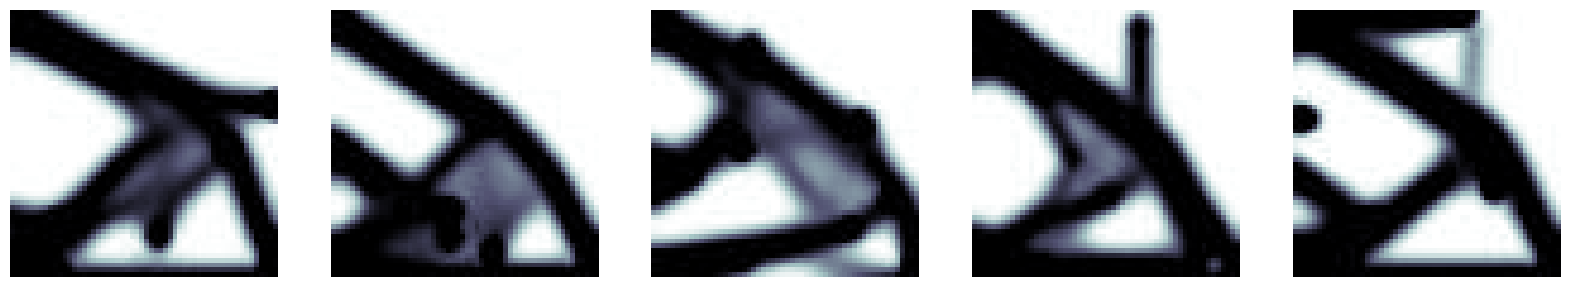

In [8]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X_train[i, 0, :, :],cmap = plt.cm.bone)
    ax.axis('off')
plt.show()

## 5. Set to model architecture

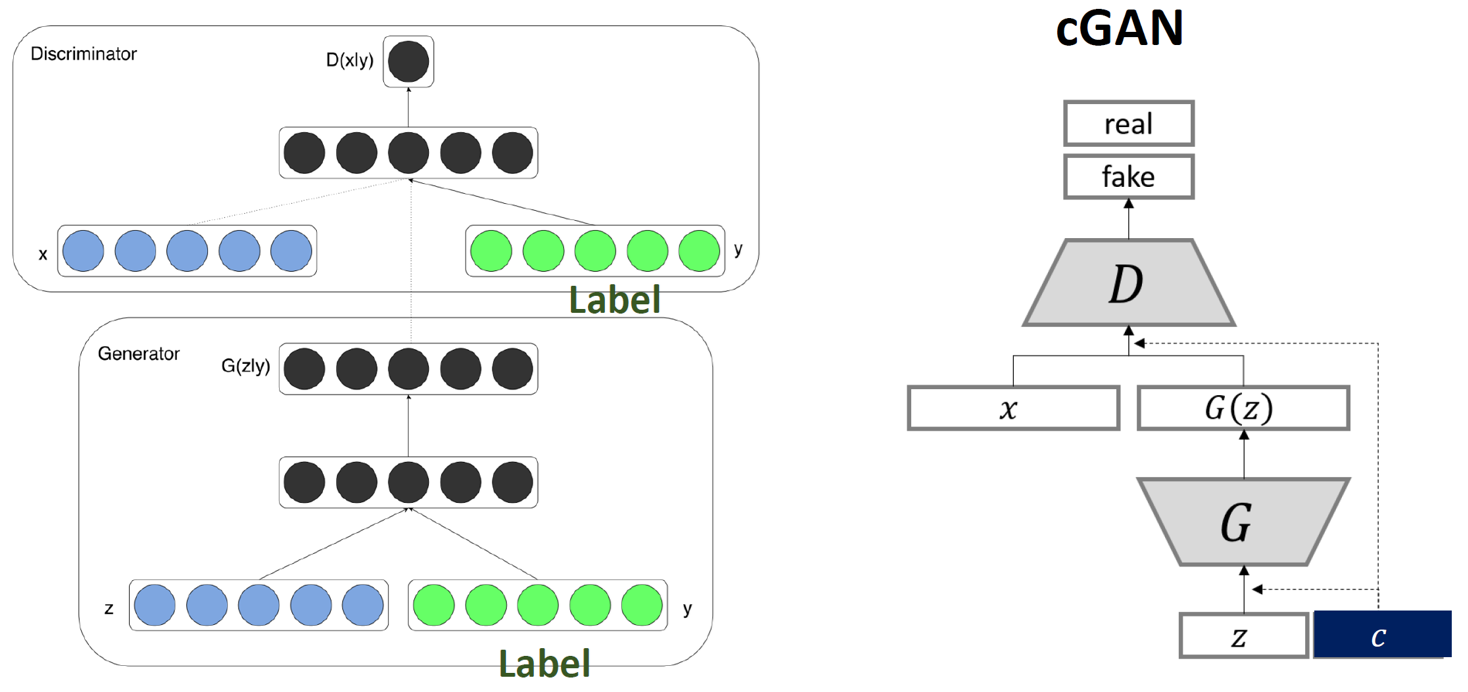

https://arxiv.org/pdf/1411.1784

https://github.com/hwalsuklee/tensorflow-generative-model-collections

In [9]:
# ---------------------
#  Generator Network (input : noise >> output : image)
# ---------------------

class Generator(nn.Module):  # generate real-looking images
    def __init__(self, noise_size, label_size, hidden_size1=256, hidden_size2=512, hidden_size3=1024, img_size=56*56):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(noise_size + label_size, hidden_size1),
            nn.ReLU(True),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(True),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(True),
            nn.Linear(hidden_size3, img_size),
            nn.Tanh()  # output values in [-1, 1]
        )

    def forward(self, noise, labels):

        gen_input = torch.cat((noise, labels), dim=1)  # concatenate noise and labels
        img = self.model(gen_input)

        return img

# ---------------------
#  Discriminator Network (input : image >> output : [1 / Real] or [0 / Fake])
# ---------------------

class Discriminator(nn.Module):  # distinguish between real and fake images
    def __init__(self, label_size, hidden_size1=256, hidden_size2=512, hidden_size3=1024, img_size=56*56):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(img_size + label_size, hidden_size3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size3, hidden_size2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size2, hidden_size1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_size1, 1),
            nn.Sigmoid()  # output probability between [0, 1]
        )

    def forward(self, img, labels):

        dis_input = torch.cat((img, labels), dim=1)  # concatenate image and labels
        validity = self.model(dis_input)

        return validity

## 6. Set model hyperparameters

In [10]:
# model architecture parameters
hidden_size1 = 256
hidden_size2 = 512
hidden_size3 = 1024
noise_size = 100
label_size = 1  # since Y is a single continuous value

# training parameters
learning_rate = 0.0002
batch_size = 32
num_epoch = 500

# fixed values
img_size = 56 * 56              # image size
num_channel = 1                 # grayscale images
img_shape = (num_channel,56,56) # grayscale images

## 7. Train model

In [11]:
# define networks and set to device (GPU)
generator = Generator(noise_size=noise_size, label_size=label_size).to(device)
discriminator = Discriminator(label_size=label_size).to(device)

# convert data to PyTorch tensors
train_images = torch.tensor(X_train, dtype=torch.float32).to(device)
train_labels = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (N, 1)

# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to loss function & optimizer
criterion = nn.BCELoss() # binary cross entropy loss for binary classification
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# lists to track training and validation history
g_loss_history = []  # generator loss history
d_loss_history = []  # discriminator loss history

In [12]:
# fixed noise and labels for visualization
fixed_labels = torch.linspace(-1, 1, steps=10).unsqueeze(1).to(device)  # example fixed labels in [-1, 1]
fixed_noise = torch.randn(10, noise_size).to(device)

# create a directory to save generated images
os.makedirs("./output/cGAN_samples/", exist_ok=True)

Epoch [1/500]  D Loss: 0.2660  G Loss: 1.4850


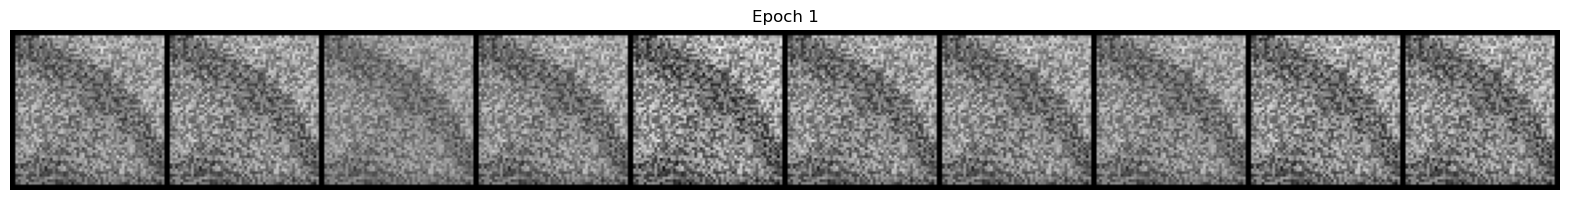

Epoch [2/500]  D Loss: 0.1251  G Loss: 3.1741
Epoch [3/500]  D Loss: 0.2744  G Loss: 2.3470
Epoch [4/500]  D Loss: 0.3223  G Loss: 2.5808
Epoch [5/500]  D Loss: 0.3534  G Loss: 3.2069
Epoch [6/500]  D Loss: 0.4384  G Loss: 3.8866
Epoch [7/500]  D Loss: 0.4575  G Loss: 7.7752
Epoch [8/500]  D Loss: 0.2259  G Loss: 5.8242
Epoch [9/500]  D Loss: 0.1363  G Loss: 5.9712
Epoch [10/500]  D Loss: 0.1545  G Loss: 4.6989
Epoch [11/500]  D Loss: 0.2339  G Loss: 4.3510
Epoch [12/500]  D Loss: 0.1714  G Loss: 4.7193
Epoch [13/500]  D Loss: 0.1114  G Loss: 5.7082
Epoch [14/500]  D Loss: 0.0956  G Loss: 5.2786
Epoch [15/500]  D Loss: 0.0655  G Loss: 5.6401
Epoch [16/500]  D Loss: 0.0266  G Loss: 5.0176
Epoch [17/500]  D Loss: 0.0361  G Loss: 4.1450
Epoch [18/500]  D Loss: 0.1480  G Loss: 5.5816
Epoch [19/500]  D Loss: 1.3965  G Loss: 8.6504
Epoch [20/500]  D Loss: 0.0606  G Loss: 5.3817
Epoch [21/500]  D Loss: 0.0785  G Loss: 11.0954
Epoch [22/500]  D Loss: 0.1165  G Loss: 10.5466
Epoch [23/500]  D L

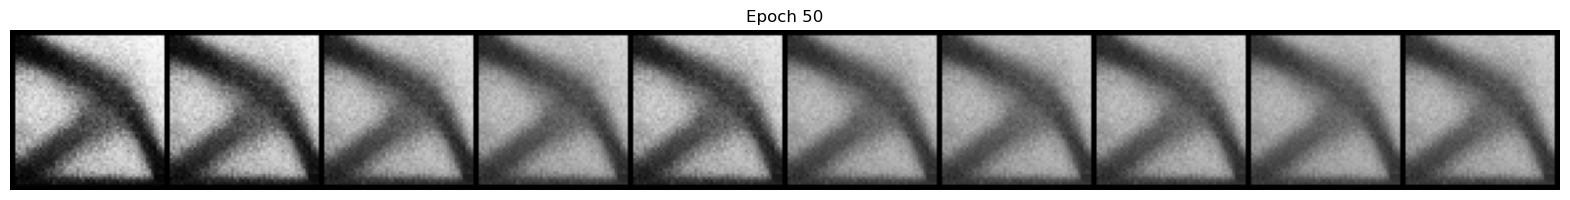

Epoch [51/500]  D Loss: 0.0979  G Loss: 3.3179
Epoch [52/500]  D Loss: 0.1018  G Loss: 4.9223
Epoch [53/500]  D Loss: 0.2945  G Loss: 3.5505
Epoch [54/500]  D Loss: 0.1868  G Loss: 2.6368
Epoch [55/500]  D Loss: 0.1164  G Loss: 5.5022
Epoch [56/500]  D Loss: 0.1353  G Loss: 3.7555
Epoch [57/500]  D Loss: 0.1060  G Loss: 4.0659
Epoch [58/500]  D Loss: 0.1145  G Loss: 4.8901
Epoch [59/500]  D Loss: 0.3055  G Loss: 3.8472
Epoch [60/500]  D Loss: 0.1434  G Loss: 3.6166
Epoch [61/500]  D Loss: 0.1256  G Loss: 3.6096
Epoch [62/500]  D Loss: 0.1818  G Loss: 3.0783
Epoch [63/500]  D Loss: 0.1575  G Loss: 4.8516
Epoch [64/500]  D Loss: 0.1196  G Loss: 4.4021
Epoch [65/500]  D Loss: 0.0884  G Loss: 4.5171
Epoch [66/500]  D Loss: 0.2880  G Loss: 2.5468
Epoch [67/500]  D Loss: 0.1167  G Loss: 3.5178
Epoch [68/500]  D Loss: 0.0950  G Loss: 4.3278
Epoch [69/500]  D Loss: 0.3595  G Loss: 2.7295
Epoch [70/500]  D Loss: 0.1126  G Loss: 2.7828
Epoch [71/500]  D Loss: 0.1004  G Loss: 4.1404
Epoch [72/500

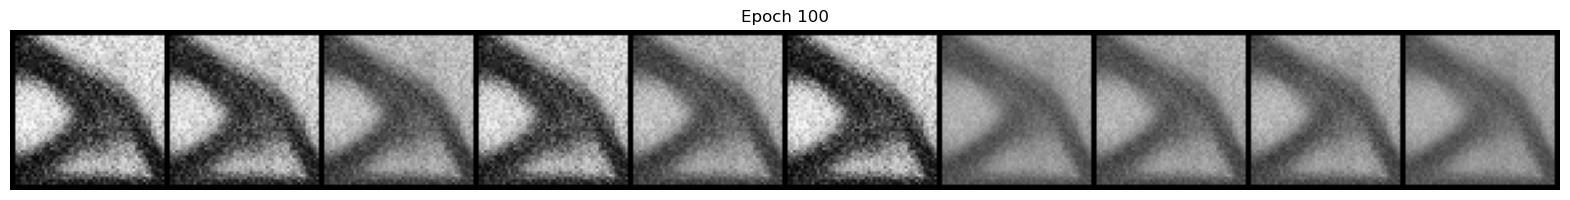

Epoch [101/500]  D Loss: 0.0754  G Loss: 3.2607
Epoch [102/500]  D Loss: 0.1280  G Loss: 3.0100
Epoch [103/500]  D Loss: 0.1050  G Loss: 4.6346
Epoch [104/500]  D Loss: 0.0976  G Loss: 4.0051
Epoch [105/500]  D Loss: 0.1126  G Loss: 3.5967
Epoch [106/500]  D Loss: 0.0621  G Loss: 5.0859
Epoch [107/500]  D Loss: 0.1536  G Loss: 5.8578
Epoch [108/500]  D Loss: 0.2617  G Loss: 3.0287
Epoch [109/500]  D Loss: 0.0606  G Loss: 4.3427
Epoch [110/500]  D Loss: 0.0887  G Loss: 3.8598
Epoch [111/500]  D Loss: 0.0513  G Loss: 3.9590
Epoch [112/500]  D Loss: 0.1308  G Loss: 4.5474
Epoch [113/500]  D Loss: 0.1229  G Loss: 5.7311
Epoch [114/500]  D Loss: 0.2290  G Loss: 3.5859
Epoch [115/500]  D Loss: 0.1243  G Loss: 3.2091
Epoch [116/500]  D Loss: 0.0725  G Loss: 4.7968
Epoch [117/500]  D Loss: 0.1896  G Loss: 3.5954
Epoch [118/500]  D Loss: 0.0957  G Loss: 3.9659
Epoch [119/500]  D Loss: 0.0763  G Loss: 4.4981
Epoch [120/500]  D Loss: 0.0742  G Loss: 4.9418
Epoch [121/500]  D Loss: 0.0679  G Loss:

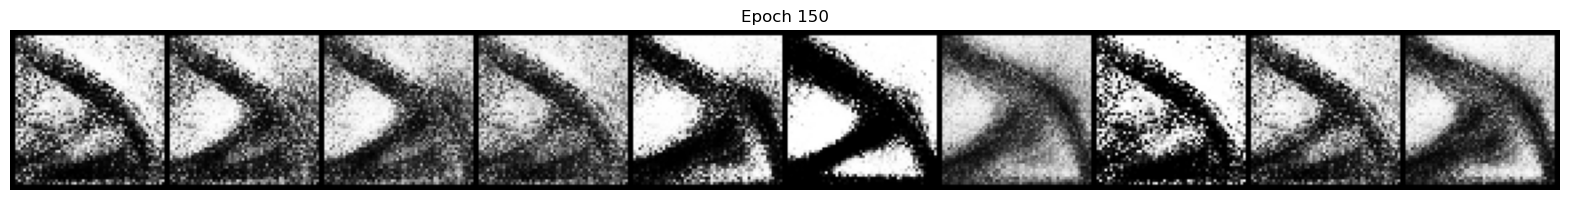

Epoch [151/500]  D Loss: 0.2121  G Loss: 3.2649
Epoch [152/500]  D Loss: 0.2654  G Loss: 2.9958
Epoch [153/500]  D Loss: 0.1954  G Loss: 3.8314
Epoch [154/500]  D Loss: 0.1632  G Loss: 4.2062
Epoch [155/500]  D Loss: 0.1944  G Loss: 3.6272
Epoch [156/500]  D Loss: 0.1199  G Loss: 4.1164
Epoch [157/500]  D Loss: 0.1593  G Loss: 4.0874
Epoch [158/500]  D Loss: 0.1552  G Loss: 4.5704
Epoch [159/500]  D Loss: 0.2502  G Loss: 4.8006
Epoch [160/500]  D Loss: 0.1972  G Loss: 3.8775
Epoch [161/500]  D Loss: 0.2399  G Loss: 3.4631
Epoch [162/500]  D Loss: 0.1467  G Loss: 3.9492
Epoch [163/500]  D Loss: 0.2247  G Loss: 3.9989
Epoch [164/500]  D Loss: 0.1583  G Loss: 4.7643
Epoch [165/500]  D Loss: 0.1776  G Loss: 3.9555
Epoch [166/500]  D Loss: 0.2486  G Loss: 3.7217
Epoch [167/500]  D Loss: 0.2047  G Loss: 3.4531
Epoch [168/500]  D Loss: 0.1608  G Loss: 3.9937
Epoch [169/500]  D Loss: 0.2256  G Loss: 3.6791
Epoch [170/500]  D Loss: 0.2184  G Loss: 3.5923
Epoch [171/500]  D Loss: 0.2876  G Loss:

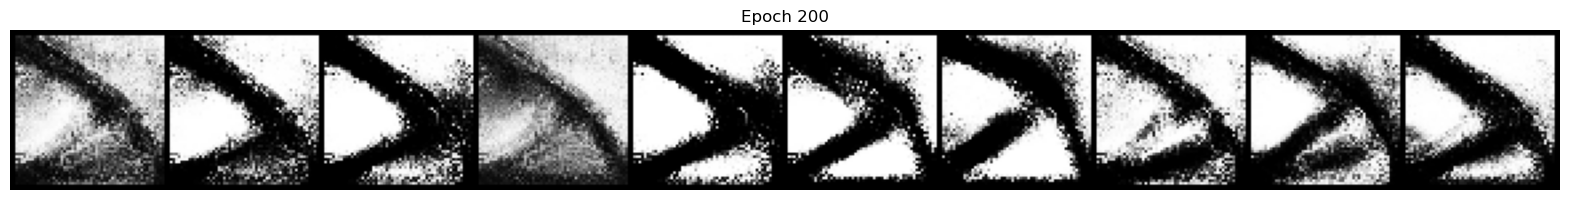

Epoch [201/500]  D Loss: 0.1782  G Loss: 3.9214
Epoch [202/500]  D Loss: 0.2313  G Loss: 3.6861
Epoch [203/500]  D Loss: 0.2059  G Loss: 3.8835
Epoch [204/500]  D Loss: 0.1992  G Loss: 3.6852
Epoch [205/500]  D Loss: 0.1801  G Loss: 3.8100
Epoch [206/500]  D Loss: 0.2019  G Loss: 3.8663
Epoch [207/500]  D Loss: 0.2181  G Loss: 3.7751
Epoch [208/500]  D Loss: 0.1911  G Loss: 3.8192
Epoch [209/500]  D Loss: 0.2243  G Loss: 3.4682
Epoch [210/500]  D Loss: 0.2035  G Loss: 3.4496
Epoch [211/500]  D Loss: 0.2433  G Loss: 3.1923
Epoch [212/500]  D Loss: 0.2328  G Loss: 3.4396
Epoch [213/500]  D Loss: 0.2246  G Loss: 3.3720
Epoch [214/500]  D Loss: 0.2102  G Loss: 3.7226
Epoch [215/500]  D Loss: 0.2191  G Loss: 3.7767
Epoch [216/500]  D Loss: 0.2550  G Loss: 3.5195
Epoch [217/500]  D Loss: 0.2116  G Loss: 3.3840
Epoch [218/500]  D Loss: 0.2125  G Loss: 3.5574
Epoch [219/500]  D Loss: 0.1815  G Loss: 3.7965
Epoch [220/500]  D Loss: 0.2164  G Loss: 3.4803
Epoch [221/500]  D Loss: 0.2201  G Loss:

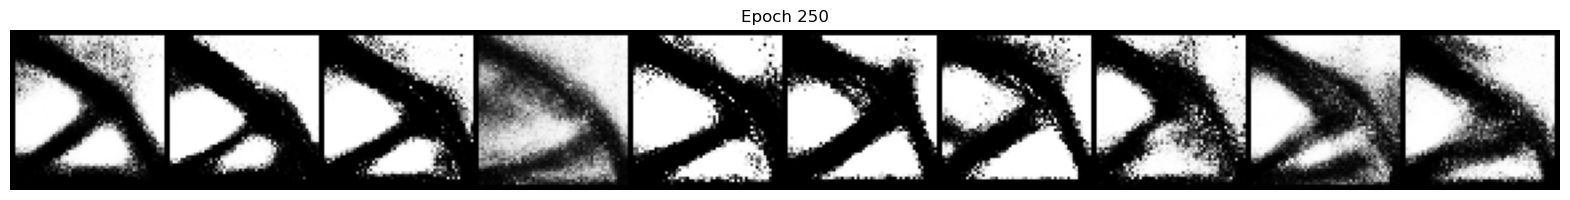

Epoch [251/500]  D Loss: 0.2725  G Loss: 2.8677
Epoch [252/500]  D Loss: 0.2454  G Loss: 3.0635
Epoch [253/500]  D Loss: 0.2868  G Loss: 3.0223
Epoch [254/500]  D Loss: 0.2446  G Loss: 3.0697
Epoch [255/500]  D Loss: 0.2666  G Loss: 3.4872
Epoch [256/500]  D Loss: 0.3099  G Loss: 2.8122
Epoch [257/500]  D Loss: 0.2750  G Loss: 2.9710
Epoch [258/500]  D Loss: 0.2537  G Loss: 3.1853
Epoch [259/500]  D Loss: 0.2201  G Loss: 3.3697
Epoch [260/500]  D Loss: 0.2782  G Loss: 3.2547
Epoch [261/500]  D Loss: 0.2447  G Loss: 3.0971
Epoch [262/500]  D Loss: 0.2345  G Loss: 3.0310
Epoch [263/500]  D Loss: 0.3144  G Loss: 2.6086
Epoch [264/500]  D Loss: 0.2328  G Loss: 3.1980
Epoch [265/500]  D Loss: 0.2756  G Loss: 3.1933
Epoch [266/500]  D Loss: 0.2971  G Loss: 2.6349
Epoch [267/500]  D Loss: 0.2523  G Loss: 3.1905
Epoch [268/500]  D Loss: 0.2914  G Loss: 3.0592
Epoch [269/500]  D Loss: 0.2193  G Loss: 3.2303
Epoch [270/500]  D Loss: 0.2777  G Loss: 3.4566
Epoch [271/500]  D Loss: 0.2343  G Loss:

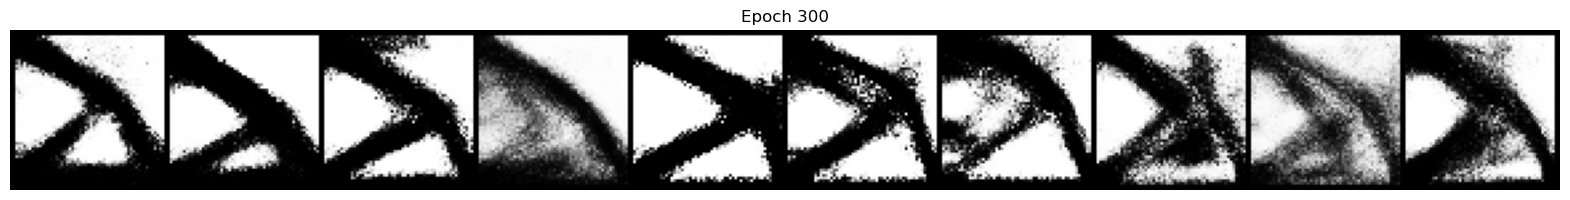

Epoch [301/500]  D Loss: 0.2971  G Loss: 2.9067
Epoch [302/500]  D Loss: 0.2824  G Loss: 3.0565
Epoch [303/500]  D Loss: 0.2502  G Loss: 3.0737
Epoch [304/500]  D Loss: 0.3295  G Loss: 2.6198
Epoch [305/500]  D Loss: 0.2936  G Loss: 2.6606
Epoch [306/500]  D Loss: 0.3082  G Loss: 2.7337
Epoch [307/500]  D Loss: 0.2701  G Loss: 3.0576
Epoch [308/500]  D Loss: 0.2986  G Loss: 2.8169
Epoch [309/500]  D Loss: 0.2916  G Loss: 2.8558
Epoch [310/500]  D Loss: 0.3295  G Loss: 2.6285
Epoch [311/500]  D Loss: 0.2943  G Loss: 2.9171
Epoch [312/500]  D Loss: 0.2982  G Loss: 2.8416
Epoch [313/500]  D Loss: 0.2890  G Loss: 2.9085
Epoch [314/500]  D Loss: 0.2801  G Loss: 3.0774
Epoch [315/500]  D Loss: 0.2913  G Loss: 2.7435
Epoch [316/500]  D Loss: 0.3197  G Loss: 2.8648
Epoch [317/500]  D Loss: 0.2925  G Loss: 2.7975
Epoch [318/500]  D Loss: 0.3078  G Loss: 2.6479
Epoch [319/500]  D Loss: 0.2998  G Loss: 2.8553
Epoch [320/500]  D Loss: 0.2939  G Loss: 2.7830
Epoch [321/500]  D Loss: 0.3313  G Loss:

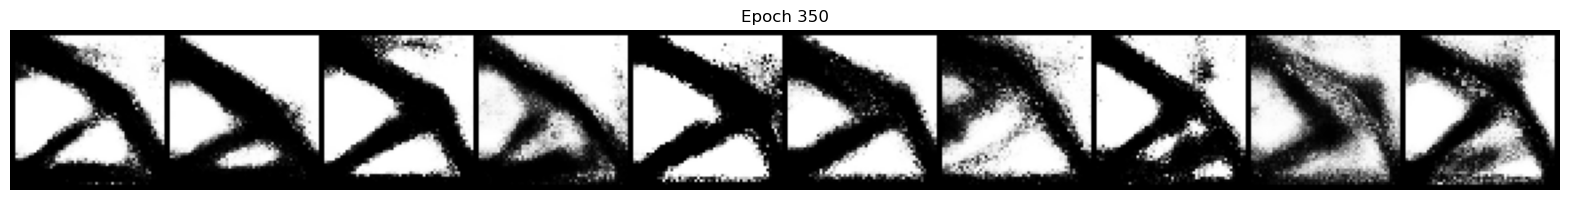

Epoch [351/500]  D Loss: 0.3647  G Loss: 2.5009
Epoch [352/500]  D Loss: 0.2845  G Loss: 2.8622
Epoch [353/500]  D Loss: 0.3203  G Loss: 2.9418
Epoch [354/500]  D Loss: 0.3286  G Loss: 2.7113
Epoch [355/500]  D Loss: 0.3051  G Loss: 2.8552
Epoch [356/500]  D Loss: 0.3049  G Loss: 2.7599
Epoch [357/500]  D Loss: 0.3069  G Loss: 2.8996
Epoch [358/500]  D Loss: 0.3610  G Loss: 2.5995
Epoch [359/500]  D Loss: 0.2837  G Loss: 2.8985
Epoch [360/500]  D Loss: 0.3282  G Loss: 2.6737
Epoch [361/500]  D Loss: 0.3265  G Loss: 2.4695
Epoch [362/500]  D Loss: 0.2625  G Loss: 3.1569
Epoch [363/500]  D Loss: 0.3424  G Loss: 2.6851
Epoch [364/500]  D Loss: 0.3042  G Loss: 2.8210
Epoch [365/500]  D Loss: 0.3122  G Loss: 2.9923
Epoch [366/500]  D Loss: 0.3264  G Loss: 2.7191
Epoch [367/500]  D Loss: 0.3058  G Loss: 2.5999
Epoch [368/500]  D Loss: 0.3169  G Loss: 2.7830
Epoch [369/500]  D Loss: 0.3075  G Loss: 2.8474
Epoch [370/500]  D Loss: 0.2861  G Loss: 3.1029
Epoch [371/500]  D Loss: 0.3290  G Loss:

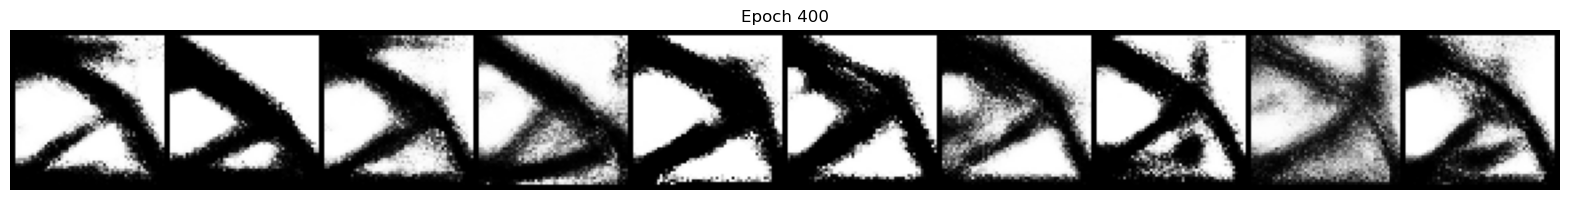

Epoch [401/500]  D Loss: 0.3650  G Loss: 2.3359
Epoch [402/500]  D Loss: 0.3332  G Loss: 2.5163
Epoch [403/500]  D Loss: 0.3114  G Loss: 2.6692
Epoch [404/500]  D Loss: 0.3084  G Loss: 2.6409
Epoch [405/500]  D Loss: 0.3549  G Loss: 2.6628
Epoch [406/500]  D Loss: 0.2976  G Loss: 2.7812
Epoch [407/500]  D Loss: 0.3372  G Loss: 2.6511
Epoch [408/500]  D Loss: 0.3291  G Loss: 2.6945
Epoch [409/500]  D Loss: 0.3274  G Loss: 2.5820
Epoch [410/500]  D Loss: 0.3288  G Loss: 2.7134
Epoch [411/500]  D Loss: 0.3370  G Loss: 2.5335
Epoch [412/500]  D Loss: 0.3231  G Loss: 2.8177
Epoch [413/500]  D Loss: 0.3718  G Loss: 2.3131
Epoch [414/500]  D Loss: 0.3261  G Loss: 2.7183
Epoch [415/500]  D Loss: 0.3344  G Loss: 2.5721
Epoch [416/500]  D Loss: 0.3459  G Loss: 2.5867
Epoch [417/500]  D Loss: 0.3254  G Loss: 2.5600
Epoch [418/500]  D Loss: 0.3155  G Loss: 2.8325
Epoch [419/500]  D Loss: 0.3467  G Loss: 2.5428
Epoch [420/500]  D Loss: 0.3156  G Loss: 2.7353
Epoch [421/500]  D Loss: 0.3452  G Loss:

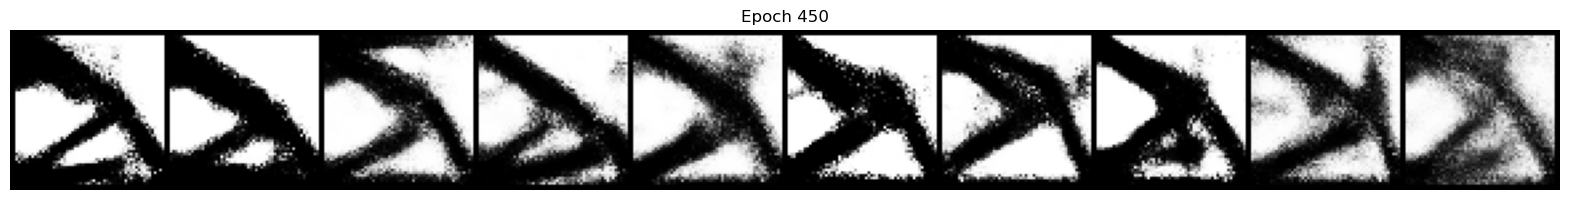

Epoch [451/500]  D Loss: 0.3443  G Loss: 2.7045
Epoch [452/500]  D Loss: 0.3500  G Loss: 2.7277
Epoch [453/500]  D Loss: 0.3274  G Loss: 2.6059
Epoch [454/500]  D Loss: 0.3162  G Loss: 2.7123
Epoch [455/500]  D Loss: 0.3284  G Loss: 2.5704
Epoch [456/500]  D Loss: 0.3190  G Loss: 2.7305
Epoch [457/500]  D Loss: 0.3267  G Loss: 2.6433
Epoch [458/500]  D Loss: 0.3171  G Loss: 2.7391
Epoch [459/500]  D Loss: 0.3235  G Loss: 2.6490
Epoch [460/500]  D Loss: 0.3341  G Loss: 2.7277
Epoch [461/500]  D Loss: 0.3026  G Loss: 2.7437
Epoch [462/500]  D Loss: 0.3069  G Loss: 2.8584
Epoch [463/500]  D Loss: 0.3346  G Loss: 2.5575
Epoch [464/500]  D Loss: 0.3202  G Loss: 2.7073
Epoch [465/500]  D Loss: 0.3204  G Loss: 2.8730
Epoch [466/500]  D Loss: 0.3461  G Loss: 2.7645
Epoch [467/500]  D Loss: 0.3075  G Loss: 2.7301
Epoch [468/500]  D Loss: 0.2870  G Loss: 3.1949
Epoch [469/500]  D Loss: 0.3303  G Loss: 2.6589
Epoch [470/500]  D Loss: 0.3580  G Loss: 2.5009
Epoch [471/500]  D Loss: 0.2892  G Loss:

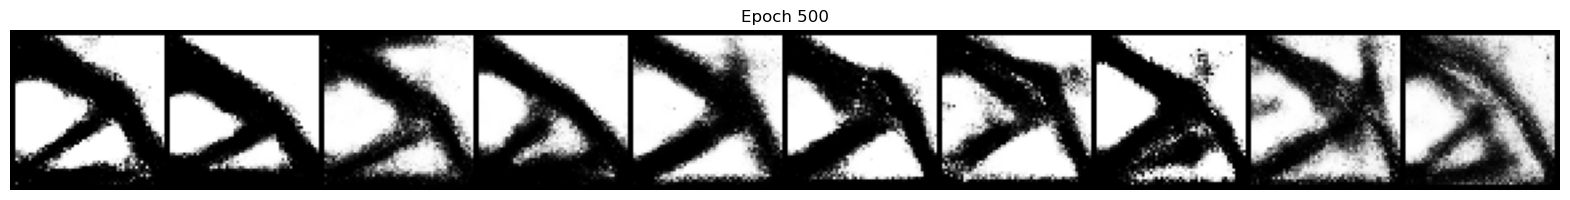

In [14]:
"""
Training part
"""
for epoch in range(1, num_epoch + 1):

    total_g_loss = 0.0  # initialize total generator loss for the epoch
    total_d_loss = 0.0  # initialize total discriminator loss for the epoch

    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_current = imgs.size(0)

        # make ground truth (labels) -> [1 / Real] & [0 / Fake]
        real = torch.ones(batch_size_current, 1).to(device)
        fake = torch.zeros(batch_size_current, 1).to(device)

        # reshape real images --> flatten to (batch_size, 56*56)
        real_imgs = imgs.view(batch_size_current, -1).to(device)  # flatten image to (batch_size, 56*56)
        labels = labels.to(device)

        # +---------------------+
        # | train Discriminator |
        # +---------------------+

        # initialize gradient -> initialize discriminator model gradient to 0
        discriminator.zero_grad()

        # discriminator loss on real images
        output_real = discriminator(real_imgs, labels)
        d_loss_real = criterion(output_real, real)

        # generate fake images and get discriminator output
        z = torch.randn(batch_size_current, noise_size).to(device)
        fake_imgs = generator(z, labels)
        output_fake = discriminator(fake_imgs.detach(), labels)
        d_loss_fake = criterion(output_fake, fake)

        # total discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2

        # train discriminator with backpropagation
        d_loss.backward()
        d_optimizer.step()

        # accumulate d_loss
        total_d_loss += d_loss.item()

        # +---------------------+
        # |   train Generator   |
        # +---------------------+

        # initialize gradient -> initialize generator model gradient to 0
        generator.zero_grad()

        # compare result of discriminator with fake images & real labels
        # if generator deceives discriminator, g_loss will decrease
        output = discriminator(fake_imgs, labels)
        g_loss = criterion(output, real)  # generator wants discriminator to label fake as real

        # train generator with backpropagation
        g_loss.backward()
        g_optimizer.step()

        # accumulate g_loss
        total_g_loss += g_loss.item()

    # calculate average losses for the epoch
    avg_g_loss = total_g_loss / len(train_loader)
    avg_d_loss = total_d_loss / len(train_loader)

    # save the average loss for this epoch
    g_loss_history.append(avg_g_loss)
    d_loss_history.append(avg_d_loss)

    # print losses at the end of each epoch
    print(f"Epoch [{epoch}/{num_epoch}]  D Loss: {avg_d_loss:.4f}  G Loss: {avg_g_loss:.4f}")

    # save and visualize generated images at specific intervals
    if epoch % 50 == 0 or epoch == 1:
        with torch.no_grad():
            # generate a set of images with a range of Y values
            fake_images = generator(fixed_noise, fixed_labels).detach().cpu()
        fake_images = fake_images.view(-1, 1, 56, 56)

        # save images as a grid using save_image
        save_image(fake_images, f"./output/cGAN_samples/cGAN_epoch_{epoch}.png", nrow=10, normalize=True)

        # display the generated images
        plt.figure(figsize=(20, 4))
        img = plt.imread(f"./output/cGAN_samples/cGAN_epoch_{epoch}.png")
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')
        plt.show()

        # optionally, save model checkpoints
        if epoch % 50 == 0 or epoch == num_epoch:
            torch.save(generator.state_dict(), f"./output/cGAN_samples/generator_epoch_{epoch}.pth")
            torch.save(discriminator.state_dict(), f"./output/cGAN_samples/discriminator_epoch_{epoch}.pth")

In [ ]:
# graph visualization
plot_loss(g_loss_history, d_loss_history, 'Learning Curve')  # loss variation over epochs during training
plt.show()

## 8. Load & Evaluate model

In [ ]:
# final image generation and visualization using 10 samples from the test dataset
with torch.no_grad():

    # select 10 samples from the test dataset
    num_samples = 10

    test_images_sample = torch.tensor(X_test[:num_samples], dtype=torch.float32).to(device)
    test_labels_sample = torch.tensor(y_test[:num_samples], dtype=torch.float32).unsqueeze(1).to(device)

    # generate fake images based on the test labels
    noise_sample = torch.randn(num_samples, noise_size).to(device)
    generated_images = generator(noise_sample, test_labels_sample).cpu()
    generated_images = generated_images.view(-1, 1, 56, 56)  # reshape generated images

    # create a figure to display the original and generated images
    fig, axs = plt.subplots(2, num_samples, figsize=(15, 4))

    for i in range(num_samples):
        # display the original image (conditions)
        axs[0, i].imshow(test_images_sample[i].cpu().numpy().reshape(56, 56), cmap='gray', vmin=-1, vmax=1)
        axs[0, i].set_title(f"Condition {i+1}\n (Y_norm={y_test[i]:.4f})\n\n Ground Truth {i+1}", fontsize=8)
        axs[0, i].axis('off')

        # display the generated image (generated images with each condition)
        axs[1, i].imshow(generated_images[i].detach().cpu().numpy().reshape(56, 56), cmap='gray', vmin=-1, vmax=1)
        axs[1, i].set_title(f"Generated\n Image {i+1}", fontsize=8)
        axs[1, i].axis('off')

    plt.show()